In [1]:
!pip install split-folders

In [2]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np
import splitfolders
import cv2
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras import layers, models

In [3]:
from google.colab import files
uploaded = files.upload()

Saving train1.zip to train1.zip


In [4]:
import zipfile

with zipfile.ZipFile("train1.zip", 'r') as zip_ref:
    zip_ref.extractall("dataset")

In [5]:
import splitfolders

splitfolders.ratio(
    input="dataset",
    output="dataset/ImageRecognition",
    seed=500,
    ratio=(0.8, 0.1, 0.1)
)

Copying files: 10000 files [00:02, 4627.84 files/s]


In [6]:
# Define the parameters
img_size = (224,224)
batch_size = 32

train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

valid_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)


train_data = train_datagen.flow_from_directory(
    "dataset/ImageRecognition/train",
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary'
)

valid_data = valid_datagen.flow_from_directory(
    "dataset/ImageRecognition/val",
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary'
)

test_data = test_datagen.flow_from_directory(
    "dataset/ImageRecognition/test",
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary'
)

Found 8000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [7]:
import os

train_dir = 'dataset/ImageRecognition/train'
val_dir = 'dataset/ImageRecognition/val'
test_dir = 'dataset/ImageRecognition/test'  # if it exists

print("Train classes:", os.listdir(train_dir))
print("Val classes:", os.listdir(val_dir))

Train classes: ['FAKE', 'REAL']
Val classes: ['FAKE', 'REAL']


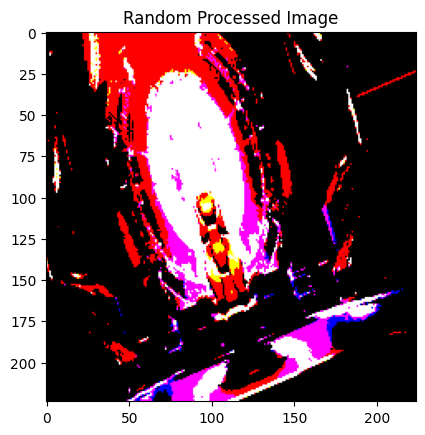

In [73]:
import random
import matplotlib.pyplot as plt

image, label = next(train_data)

idx = random.randint(0, image.shape[0] - 1)

plt.imshow(image[idx])
plt.title("Random Processed Image")
plt.show()

In [9]:
from tensorflow.keras.applications import ResNet50

base_model = ResNet50(
    weights='imagenet',
    include_top=False,
    input_shape=(img_size[0], img_size[1], 3)
)

base_model.trainable = False

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


In [10]:
from tensorflow.keras import layers, models

model = models.Sequential([
    base_model,

    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),

    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')  # binary classification
])

In [11]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [16]:
model.fit(train_data, epochs=15, validation_data=valid_data)

Epoch 1/15
250/250 ━━━━━━━━━━━━━━━━━━━━ 105s 420ms/step - accuracy: 0.9276 - loss: 0.1807 - val_accuracy: 0.8800 - val_loss: 0.3386
Epoch 2/15
250/250 ━━━━━━━━━━━━━━━━━━━━ 101s 404ms/step - accuracy: 0.9364 - loss: 0.1625 - val_accuracy: 0.8670 - val_loss: 0.4162
Epoch 3/15
250/250 ━━━━━━━━━━━━━━━━━━━━ 140s 397ms/step - accuracy: 0.9346 - loss: 0.1613 - val_accuracy: 0.8600 - val_loss: 0.4196
Epoch 4/15
250/250 ━━━━━━━━━━━━━━━━━━━━ 102s 409ms/step - accuracy: 0.9388 - loss: 0.1574 - val_accuracy: 0.8670 - val_loss: 0.4624
Epoch 5/15
250/250 ━━━━━━━━━━━━━━━━━━━━ 141s 404ms/step - accuracy: 0.9462 - loss: 0.1468 - val_accuracy: 0.8520 - val_loss: 0.5563
Epoch 6/15
250/250 ━━━━━━━━━━━━━━━━━━━━ 103s 412ms/step - accuracy: 0.9460 - loss: 0.1384 - val_accuracy: 0.8520 - val_loss: 0.5476
Epoch 7/15
250/250 ━━━━━━━━━━━━━━━━━━━━ 101s 403ms/step - accuracy: 0.9583 - loss: 0.1160 - val_accuracy: 0.8640 - val_loss: 0.5125
Epoch 8/15
250/250 ━━━━━━━━━━━━━━━━━━━━ 102s 409ms/step - accuracy: 0.9496 -

In [43]:
test_loss, test_acc = model.evaluate(test_data)
print(f'Test accuracy: {test_acc * 100:.2f}%')
print(f'Test loss: {test_loss:.4f}')

32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 84ms/step - accuracy: 0.8729 - loss: 0.5536
Test accuracy: 87.30%
Test loss: 0.5272


In [47]:
class_name = {0:'FAKE',1:'REAL'}
img_size = (224, 224)
def predict_img(image_path, model):
    test_img = cv2.imread(image_path)
    test_img = cv2.resize(test_img, img_size)
    test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)
    test_img = preprocess_input(test_img)
    test_img = np.expand_dims(test_img, axis=0)

    result = model.predict(test_img)[0][0]
    prediction = 1 if result >= 0.5 else 0
    print(f"Prediction: {class_name[prediction]}")
    return class_name[prediction]

Saving 0056.jpg to 0056.jpg


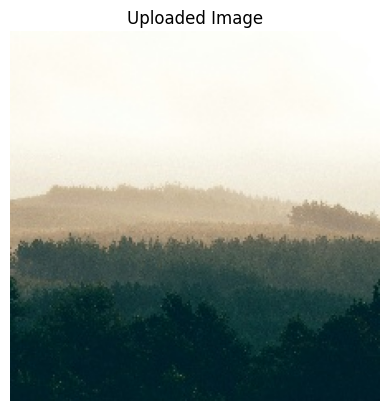

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Prediction: REAL


'REAL'

In [50]:
uploaded = files.upload()
for filename in uploaded.keys():
    image_path = filename
    break  # just use the first uploaded image

# Display the image
img = cv2.imread(image_path)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.title("Uploaded Image")
plt.axis("off")
plt.show()

predict_img(image_path, model)